# Latitude by Latitude Quantile Plots
This notebook produces plots to illustrate how the high quantiles for near surface air temperature vary with longwave optical depth ($CO_2$ concentration proxy) on an aquaplanet.

It combines all simulations run in each plot.

It is similar to `quantile_notebook2_summer.ipynb` except that it combines variables and theories for each latitude independently before area averaging them in the final plots.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy, lapse_moist
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating

2023-05-17 08:35:48,525 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [3]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))[var_keep]
        ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


In [4]:
quantiles_all = np.arange(1, 100)
median_quant_ind = np.where(quantiles_all==50)[0][0]
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
# two different types of temperature quantiles, p is actual percentile. x is averaged over given percentile.
temp_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
mse_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
temp_median = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.mean(dim='lon_time')
        temp_median[i] = ds_all[i].temp.median(dim='lon_time')
        mse_mean[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height).mean(dim='lon_time')
        temp_quant_p[i] = ds_all[i].temp.quantile(quantiles_all/100, dim='lon_time').transpose()
        sphum_quant_p[i] = ds_all[i].sphum.quantile(quantiles_all/100, dim='lon_time').transpose()
        mse_quant_p[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum,
                                             ds_all[i].height).quantile(quantiles_all/100, dim='lon_time').transpose()
        pbar.update(1)

100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


In [5]:
# For given quantiles, plot quantile vs average temp for each latitude.
# Then fit best line to this to get simulated gradient, combining all kappa values
quant_plot = [90, 95, 99]
quant_plot_ind = numpy_indexed.indices(quantiles_all, quant_plot)
n_quant_plot = len(quant_plot)
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

def get_gradient(temp_quant, temp_av, ref_ind):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int

    Returns:
        int
            Gradient
        [n_exp]
            Predicted temperature for each experiment
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[0]
    return param, fit_func(temp_av, param)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
temp_quant_grad = np.zeros((n_lat, n_quant_plot))
temp_quant_grad_fit = np.zeros((n_exp, n_lat, n_quant_plot))
for i in range(n_lat):
    for j in range(n_quant_plot):
        temp_quant_grad[i, j], temp_quant_grad_fit[:, i, j] = get_gradient(temp_quant_p[:, i, quant_plot_ind[j]],
                                                                           temp_mean[:, i], tau_ref_ind)

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

In [6]:
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

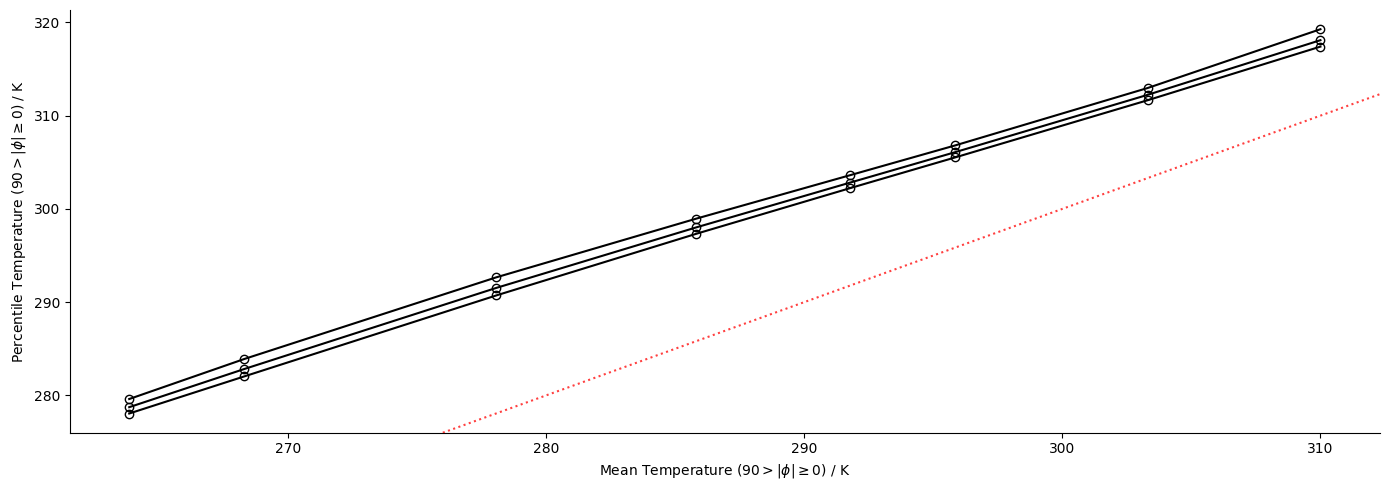

In [7]:
trend_line_on = False
save_trend_fig = False

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

temp_mean_weight = np.average(temp_mean, axis=1, weights=lat_weights)
temp_quant_weight = np.average(temp_quant_p, axis=1, weights=lat_weights)

fig, ax = plt.subplots(1,1, figsize=(14, 5))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    ax.plot(temp_mean_weight,
            temp_quant_weight[:, quant_plot_ind[j]],
            marker='o',
            label='{}$^{}$ ({:.2f} K/K)'.format(quant_plot[j],'{th}', np.average(temp_quant_grad[:, j], weights=lat_weights)),
            color='k', fillstyle='none')
    if trend_line_on:
        # Filled circle for reference simulation
        ax.plot(temp_mean_weight[tau_ref_ind],
                temp_quant_weight[tau_ref_ind, quant_plot_ind[j]],
                marker='o', color='k', fillstyle='full')
        if j==n_quant_plot-1:
            label = 'Linear Increase'
        else:
            label = None
        ax.plot(temp_mean_weight,
                np.average(temp_quant_grad_fit[:, :, j], axis=1, weights=lat_weights),
                linestyle=':', color='k', alpha=0.3, label=label)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([ax.get_ylim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
if trend_line_on:
    ax.legend(title='Percentile - Gradient', frameon=False)
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax.set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
plt.tight_layout()
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for predicting next temperature based on the previous $\kappa$
This adds the theory prediction of temperature percentile to the above plot. The theory can predict the temperature at the next kappa value based on the previous optical depth value.

In [8]:
# get theory predictions for all quantiles
delta_temp_quant = np.diff(temp_quant_p, axis=0)
delta_temp_median = np.diff(temp_median, axis=0)
delta_mse_ratio = np.diff(mse_quant_p, axis=0)/np.expand_dims(np.diff(mse_mean, axis=0), axis=-1)

delta_temp_quant_theory = {method: np.zeros((n_exp-1, n_lat, n_quant_all)) for method in
                           ['linear', 'const_rh', 'squared', 'squared_lambda']}
# theory1 adds theoretical delta_temp to simulated value of previous kappa
temp_quant_theory = {'linear': temp_quant_p.copy(), 'const_rh': temp_quant_p.copy()}
# theory2 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory2 = {method: temp_quant_p.copy() for method in ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in delta_temp_quant_theory:
    for i in range(n_lat):
        delta_temp_quant_theory[method][:, i] = \
                get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant_p[:, i], sphum_quant_p[:, i], p_surface,
                                            const_rh=True if method=='const_rh' else False,
                                            delta_mse_ratio=delta_mse_ratio[:, i] if 'lambda' in method else None,
                                            taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')
        if method[0] != 's':
            # only need linear and const_rh for this version of theoretical prediction
            temp_quant_theory[method][1:] = temp_quant_p[:-1] + delta_temp_quant_theory[method]
    for j in range(n_exp-1):
        temp_quant_theory2[method][1+j] = temp_quant_theory2[method][j] + delta_temp_quant_theory[method][j]

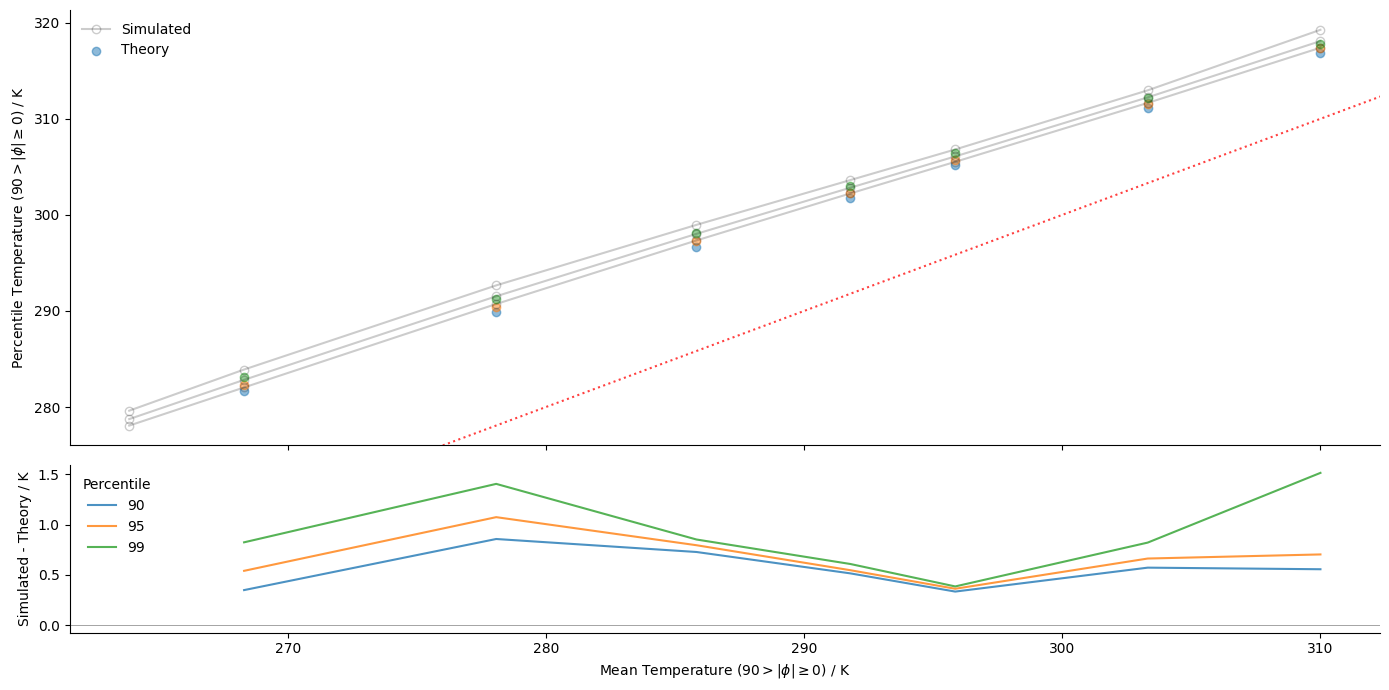

In [9]:
# which version of theory to plot - linear is full theory, and const_rh assumes constant relative humidity
# theory_method = 'const_rh'
theory_method = 'linear'
save_trend_theory_fig = False

fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2.6, 1]})
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    ax[0].plot(temp_mean_weight, temp_quant_weight[:, quant_plot_ind[j]],
               marker='o', color='k', fillstyle='none', alpha=0.2)
    ax[0].scatter(temp_mean_weight[1:],
                  np.average(temp_quant_theory[theory_method][:, :, quant_plot_ind[j]], axis=1, weights=lat_weights)[1:], alpha=0.5)
    ax[1].plot(temp_mean_weight[1:],
               temp_quant_weight[1:, quant_plot_ind[j]]-
               np.average(temp_quant_theory[theory_method][:, :, quant_plot_ind[j]], axis=1, weights=lat_weights)[1:],
               label=quant_plot[j], alpha=0.8)
ax[0].legend(['Simulated', 'Theory'], loc='upper left', frameon=False)
ax[1].legend(title='Percentile', loc='upper left', frameon=False)
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[1].hlines(0, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax[0].plot([ax[0].get_ylim()[0], ax[0].get_xlim()[1]], [ax[0].get_ylim()[0], ax[0].get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
if season == 'summer':
    ax[-1].set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax[-1].set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax[1].set_ylabel('Simulated - Theory / K')
plt.tight_layout()
if save_fig or save_trend_theory_fig:
    file_name = f'{region.lower()}_theory_const_rh' if theory_method=='const_rh' else f'{region.lower()}_theory'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

The plot below is like that above, but is showing the predicted amplification factor compared to the actual one. The denominator in $\delta T(x)/\delta \overline{T}$ is the change in the median temperature as the theory can predict this too.

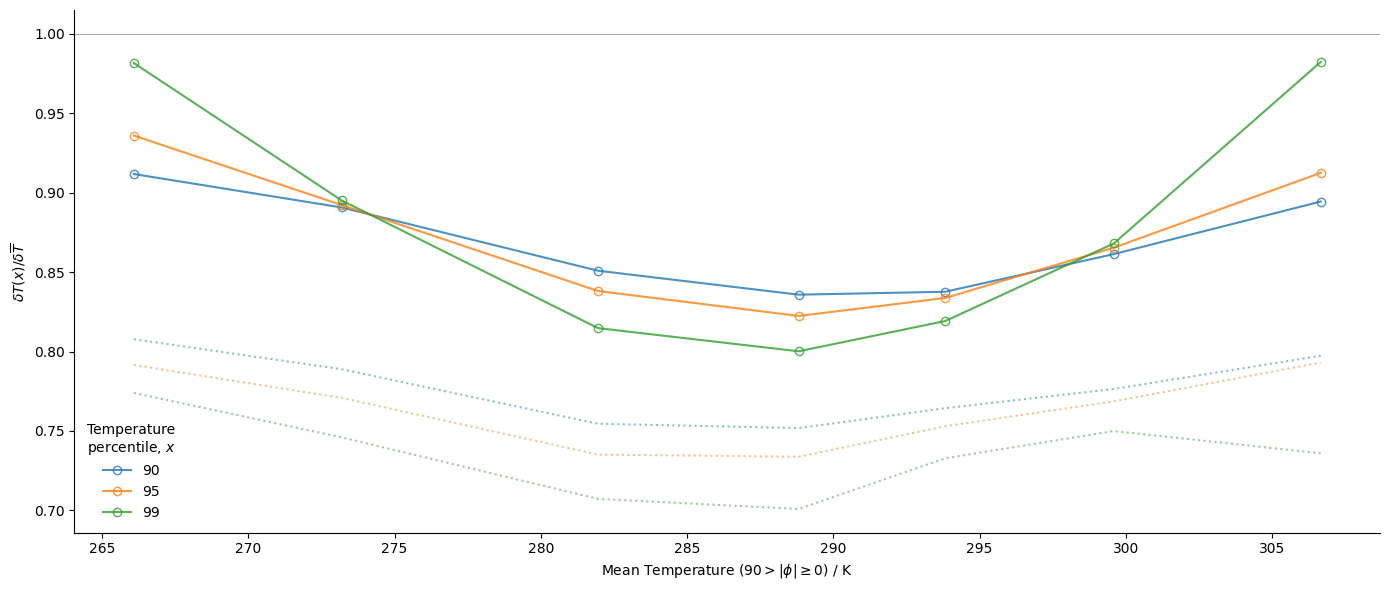

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_amp_factor_fig=False
fig, ax = plt.subplots(1,1, figsize=(14, 6))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    # for difference between simulations, make x-axis the average between the two mean temperatures
    ax.plot(moving_average(temp_mean_weight, 2),
            np.average(delta_temp_quant[:, :, quant_plot_ind[j]]/delta_temp_median, axis=1, weights=lat_weights),
            color=default_colors[j], alpha=0.8, marker='o', fillstyle='none', label=quant_plot[j])
    ax.plot(moving_average(temp_mean_weight, 2),
            np.average(delta_temp_quant_theory[theory_method][:, :, quant_plot_ind[j]]/
                       delta_temp_quant_theory[theory_method][:, :, median_quant_ind],
                       axis=1, weights=lat_weights), color=default_colors[j], linestyle=':', alpha=0.5)
ax.legend(title='Temperature\npercentile, $x$', frameon=True, framealpha=1, edgecolor="white")
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax.set_xlim(xlim)
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax.set_ylabel('$\delta T(x)/\delta \overline{T}$')
plt.tight_layout()
if save_fig or save_amp_factor_fig:
    file_name = f'{region.lower()}_amplification_factor_const_rh' if theory_method=='const_rh' else \
        f'{region.lower()}_amplification_factor'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Figure 2 of Byrne 2021 - combining $\kappa$
The gradients in the above plot indicate the scaling factors shown in the bottom plot of Byrne 2021 figure 2, but combine all $\kappa$ values indicated by `scaling_factor_kappa_use`. So I plot the gradients versus percentile, $x$, here to replicate the figure.

I include the option for two different quantiles. In Byrne 2021, it is the temperatures averaged over a given percentile - I refer to this as `temp_quant_x`. The other option is using the actual percentile, given here as `temp_quant_p`.

For the mean below, I don't use area weighting, whereas I do above, hence the difference. I don't use it below so that `temp_quant_x` plot always shows a scaling factor of $1$ for $x=0$.

To see if the scaling factor is different for warmer vs colder climates, I compute the gradients using a subset of $\kappa$ values. For colder climates, I use $\kappa=0.2, 0.3, 0.6, 1$ and force the line through $\kappa=1$. For warmer climates, I use $\kappa=1, 1.5, 2, 3.5, 6$ and force the line through $\kappa=1$. The solid line includes all $\kappa$ and is forced through $\kappa = 1$.

In [11]:
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j] = get_gradient(temp_quant_p[sf_tau_use[i], k, j], temp_median[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            for method in scaling_factor_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[method][i, k, j] = get_gradient(temp_quant_theory2[method][sf_tau_use[i], k, j],
                                                           temp_quant_theory2[method][sf_tau_use[i], k, median_quant_ind],
                                                           sf_tau_ref_ind)[0]

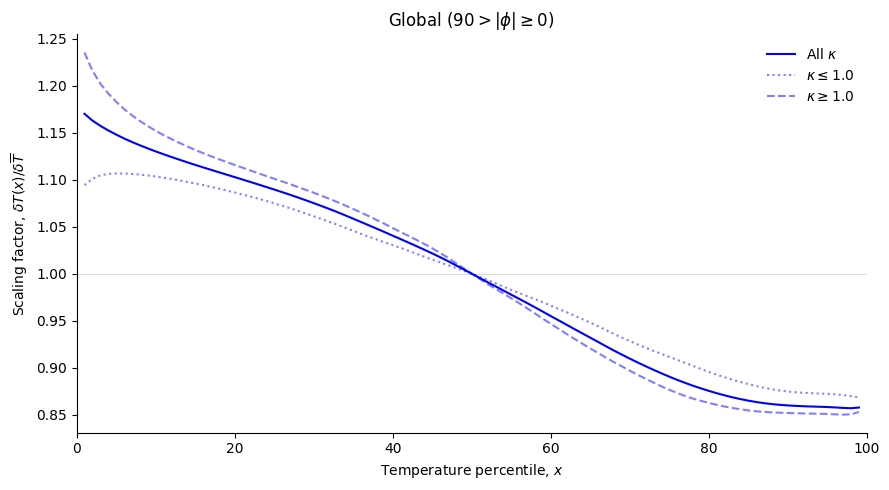

In [12]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='b', label='All $\kappa$')
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='b', linestyle=':', alpha=0.5,
        label=f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='b', linestyle='--', alpha=0.5,
        label= f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend(frameon=False)
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

The solid blue line below is the same as that above. The black lines show the theoretical prediction for the blue line, combining all kappa values.

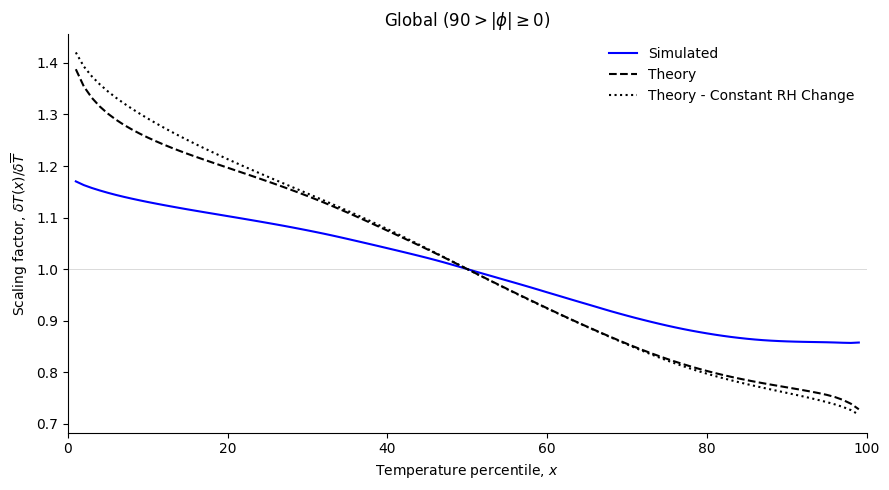

In [13]:
save_sf_theory_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='b', label='Simulated')
ax.plot(quantiles_all, np.average(scaling_factor_theory['linear'][0], axis=0, weights=lat_weights), color='k', linestyle='--',
        label=f'Theory')
ax.plot(quantiles_all, np.average(scaling_factor_theory['const_rh'][0], axis=0, weights=lat_weights), color='k', linestyle=':',
        label= f'Theory - Constant RH Change')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(2)
# ax.lines.pop(1)
ax.legend(frameon=False)
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Approximations of Theory
Below, I investigate the 3 approximations that go into the aquaplanet theory.

In [14]:
lambda_p = {var: np.zeros((n_sf, n_lat, n_quant_all)) for var in ['temp', 'sphum', 'mse', 'mse2']}

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            lambda_p['temp'][i, k, j] = get_gradient(temp_quant_p[sf_tau_use[i], k, j], temp_mean[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            lambda_p['sphum'][i, k, j] = get_gradient(sphum_quant_p[sf_tau_use[i], k, j], sphum_mean[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            lambda_p['mse'][i, k, j] = get_gradient(mse_quant_p[sf_tau_use[i], k, j], mse_mean[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            lambda_p['mse2'][i, k, j] = get_gradient(c_p * temp_quant_p[sf_tau_use[i], k, j] + L_v * sphum_quant_p[sf_tau_use[i], k, j],
                                                     c_p * temp_mean[sf_tau_use[i], k] + L_v * sphum_mean[sf_tau_use[i], k],
                                                     sf_tau_ref_ind)[0]

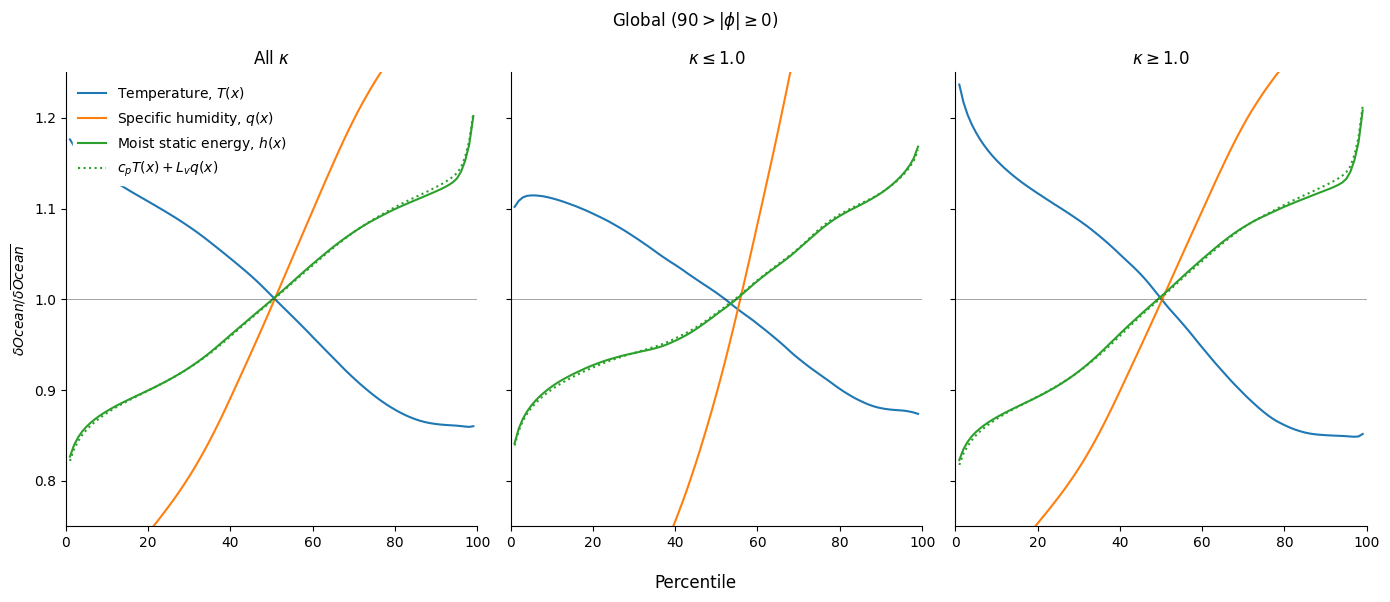

In [15]:
save_lambda_fig = False
fig, ax = plt.subplots(1,3, figsize=(14, 6), sharey=True, sharex=True)
labels = ['Temperature, $T(x)$','Specific humidity, $q(x)$', 'Moist static energy, $h(x)$']
for i in range(n_sf):
    ax[i].spines[['right', 'top']].set_visible(False)
    for j, var in enumerate(['temp', 'sphum', 'mse']):
        ax[i].plot(quantiles_all, np.average(lambda_p[var][i], axis=0, weights=lat_weights), label=labels[j])
    ax[i].plot(quantiles_all, np.average(lambda_p['mse2'][i], axis=0, weights=lat_weights), label='$c_p T(x) + L_v q(x)$',
               color=default_colors[2], linestyle=':')
    ax[i].hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
ax[0].legend(frameon=True, framealpha=1, edgecolor='white')
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
fig.supxlabel('Percentile')
ax[0].set_ylabel('$\delta Ocean/\delta \overline{Ocean}$')
ax[0].set_ylim(0.75,1.25)
ax[0].set_xlim(0, 100)
fig.suptitle(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta Ocean/\delta \overline{Ocean}$ plot above. This should be equal to 1.
    In the plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown by comparing the green lines in the $\delta Ocean/\delta \overline{Ocean}$ plot above. If this approximation was exact, we would expect them to match up exactly.
   In the plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

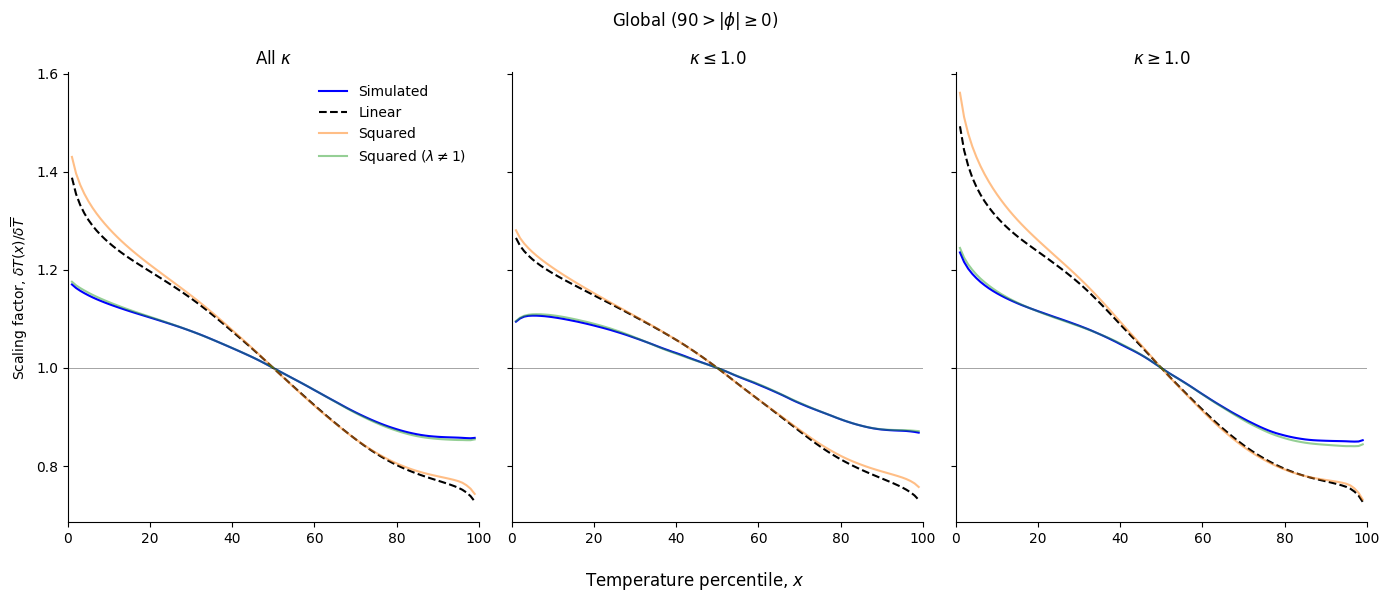

In [16]:
save_approx_fig = True
fig, ax = plt.subplots(1,3, figsize=(14, 6), sharex=True, sharey=True)

ax[1].spines[['right', 'top']].set_visible(False)
for i in range(n_sf):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].plot(quantiles_all, np.average(scaling_factor[i], axis=0, weights=lat_weights), label = 'Simulated', color='b')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['linear'][i], axis=0, weights=lat_weights),
               label='Linear', color='k', linestyle='--')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['squared'][i], axis=0, weights=lat_weights),
               label='Squared', color=default_colors[1], alpha=0.5)
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['squared_lambda'][i], axis=0, weights=lat_weights),
               label='Squared ($\lambda \\neq 1$)', color=default_colors[2], alpha=0.5)
    ax[i].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax[0].legend(frameon=False)
fig.supxlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[0].set_xlim(0,100)
fig.suptitle(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/scaling_factor_approx_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Miyawaki 2022 analysis
First I get the $R_1$ parameter and the lapse rate deviation from the moist adiabat, averaged over two different pressure ranges - one for the free troposphere and one for the boundary layer.

In [17]:
def get_r1_from_ds(dataset, albedo, include_storage:bool = True):
    # Compute the r1 variable at each latitude and longitude for all times in a year
    dt = 24 * 60**2  # one time step is 1 day in seconds
    dm_dt = np.zeros([dataset.sizes['time'], dataset.sizes['lat'], dataset.sizes['lon']])
    for i in range(dataset.lat.size):
            dm_dt[:, i, :] = get_dmse_dt(dataset.temp[:,:,i], dataset.sphum[:,:,i], dataset.height[:,:,i],
                                         dataset.pfull*100, dataset.time*dt, zonal_mean=False)[1]
    R_a = frierson_atmospheric_heating(dataset, albedo)
    dvm_dy = get_dvmse_dy(R_a, dataset.flux_lhe, dataset.flux_t, dm_dt)
    if include_storage:
        return get_r1(R_a, dm_dt, dvm_dy)
    else:
        return get_r1(R_a, dm_dt * 0, dvm_dy)

def get_lapse_dev(dataset, sigma_min_array, sigma_max_array):
    # Finds lapse rate dev in each sigma range given - assumed to be more than 1
    sigma = dataset.pfull/dataset.pfull[-1]
    lapse_actual = np.gradient(dataset.temp, dataset.pfull*100, axis=1)
    lapse_adiabat = lapse_moist(dataset.temp, dataset.pfull*100, pressure_coords=True)
    lapse_dev = []
    for i in range(len(sigma_min_array)):
        use_sigma = np.logical_and(sigma>=sigma_min_array[i], sigma<=sigma_max_array[i]).to_numpy()
        lapse_dev += [(100*(lapse_adiabat - lapse_actual)/lapse_adiabat)[:, use_sigma].mean(dim=['pfull', 'time', 'lon'])]
    return np.asarray(lapse_dev)

def get_lapse_dev_from_mean(dataset, temp_thresh, sigma_min_array, sigma_max_array):
    # Finds lapse rate dev of all days above temp_thresh in each sigma range given - assumed to be more than 1
    sigma = dataset.pfull/dataset.pfull[-1]
    lapse_actual = np.gradient(dataset.temp, dataset.pfull*100, axis=1)
    lapse_mean_all_p = np.nanmedian(lapse_actual, axis=(0,3))      # [n_pressure x n_lat]
    n_lat = len(temp_thresh)
    n_sigma = len(sigma_min_array)
    use_sigma = np.zeros((n_sigma, sigma.size), dtype=bool)
    lapse_mean = np.zeros((n_sigma, n_lat))
    for i in range(n_sigma):
        use_sigma[i] = np.logical_and(sigma>=sigma_min_array[i], sigma<=sigma_max_array[i])
        lapse_mean[i] = lapse_mean_all_p[use_sigma[i]].mean(axis=0)
    lapse_actual = np.moveaxis(lapse_actual, 0, 2)
    lapse_dev = np.zeros((n_sigma, n_lat))
    for j in range(n_lat):
        keep_quant = dataset.sel(lat=dataset.lat[j]).temp[:, -1]>=temp_thresh[j]
        lapse_j = np.nanmedian(lapse_actual[:, j, keep_quant], axis=-1)   # [n_pressure]
        for i in range(n_sigma):
            lapse_dev[i, j] = (100*(lapse_mean[i, j] - lapse_j[use_sigma[i]].mean())/lapse_mean[i, j])
            # lapse_dev[i, j] = (100*(lapse_j[use_sigma[i]].mean() - lapse_mean[i, j])/lapse_j[use_sigma[i]].mean())
    return lapse_dev

def get_lapse_dev_from_mean2(dataset, temp_thresh, sigma_min_array, sigma_max_array):
    # Finds lapse rate dev of all days above temp_thresh in each sigma range given - assumed to be more than 1
    # Difference to get_lapse_dev_from_mean, is that here, we compute average temperature at each pressure level and then compute
    # lapse rate for this average profile rather than computing the lapse rate for each profile and then averaging over those
    sigma = dataset.pfull/dataset.pfull[-1]
    lapse_mean_all_p = np.gradient(dataset.temp.mean(dim=['lon', 'time']), dataset.pfull*100, axis=0)   # [n_pressure x n_lat]
    n_lat = len(temp_thresh)
    n_sigma = len(sigma_min_array)
    use_sigma = np.zeros((n_sigma, sigma.size), dtype=bool)
    lapse_mean = np.zeros((n_sigma, n_lat))
    for i in range(n_sigma):
        use_sigma[i] = np.logical_and(sigma>=sigma_min_array[i], sigma<=sigma_max_array[i])
        lapse_mean[i] = lapse_mean_all_p[use_sigma[i]].mean(axis=0)
    lapse_dev = np.zeros((n_sigma, n_lat))
    for j in range(n_lat):
        dataset_j = dataset.sel(lat=dataset.lat[j]).stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        keep_quant = (dataset_j.temp[-1]>=temp_thresh[j]).to_numpy()
        # print(dataset_j.temp.shape)
        # print(keep_quant.shape)
        dataset_j = dataset_j.temp.transpose()
        # print(dataset_j.shape)
        # print(keep_quant)
        dataset_j = dataset_j[keep_quant].mean(dim='lon_time')
        lapse_j = np.gradient(dataset_j, dataset.pfull*100, axis=0)   # [n_pressure]
        for i in range(n_sigma):
            lapse_dev[i, j] = (100*(lapse_mean[i, j] - lapse_j[use_sigma[i]].mean())/lapse_mean[i, j])
            # lapse_dev[i, j] = (100*(lapse_j[use_sigma[i]].mean() - lapse_mean[i, j])/lapse_j[use_sigma[i]].mean())
    return lapse_dev

In [18]:
# This cell is slow, don't run to save time
var_keep_r1 = ['temp', 'sphum', 'height', 'swdn_toa', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 'olr', 'flux_lhe', 'flux_t']
r1_mean = np.zeros((n_exp, n_lat))
r1_median = np.zeros((n_exp, n_lat))
r1_std = np.zeros((n_exp, n_lat))
r1_quant_plot = np.zeros((n_exp, n_quant_plot, n_lat))      # get r1 averaged over warm days
r1_quant_plot_median = np.zeros((n_exp, n_quant_plot, n_lat))

# get lapse rate deviation at the two atmospheric regions given in miyawaki 2022
sigma_min = [0.3, 0.9]
sigma_max = [0.7, 1]
n_sigma = len(sigma_min)
lapse_dev = np.zeros((n_exp, n_sigma, n_lat))
lapse_dev_quant_plot = np.zeros((n_exp, n_sigma, n_quant_plot, n_lat))
lapse_dev_from_mean = np.zeros((n_exp, n_sigma, n_quant_plot, n_lat))

for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))[var_keep_r1]
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
    if season == 'summer':
        # Only consider summer as has expected circulation
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
        # Combine hemispheres and average over longitude, time and latitude.
        # Note that April, May, June, October, November and December will not be included in this dataset
        ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
    ds_use = ds_use.load()
    r1_all = get_r1_from_ds(ds_use, albedo[i])
    r1_mean[i] = r1_all.mean(dim=['lon', 'time'])
    r1_median[i] = r1_all.median(dim=['lon', 'time'])
    r1_std[i] = median_abs_deviation(r1_all.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)),
                                     nan_policy='omit', axis=1)       # use median deviation as more robust
    lapse_dev[i] = get_lapse_dev(ds_use, sigma_min, sigma_max)
    for j, quant_use in enumerate(quant_plot_ind):
        # this dev_from_mean is slow - get rid to save time
        lapse_dev_from_mean[i, :, j] = get_lapse_dev_from_mean2(ds_use, temp_quant_p[i, :, quant_plot_ind[j]], sigma_min, sigma_max)
        for k in range(n_lat):
            keep = ds_use.sel(lat=ds_use.lat[k]).temp[:, -1]>=temp_quant_p[i, k, quant_plot_ind[j]]
            r1_quant_plot[i, j, k] = r1_all.sel(lat=ds_use.lat[k]).where(keep).mean()
            r1_quant_plot_median[i, j, k] = r1_all.sel(lat=ds_use.lat[k]).where(keep).median()
            lapse_dev_quant_plot[i, :, j, k] = get_lapse_dev(ds_use.sel(lat=ds_use.lat[k]).where(keep), sigma_min, sigma_max)

 12%|█▎        | 1/8 [03:51<27:01, 231.64s/it]

KeyboardInterrupt



In [ ]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av

save_miyawaki_scatter = False
warm_quant_use = 0
warm_colors = plt.cm.turbo(np.linspace(0,1,n_exp+2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i in range(n_exp-1):
    ax.scatter(abs_lat_av(r1_quant_plot_median[i, 0]),
               abs_lat_av(np.median(delta_mse_ratio[i,:,quant_plot_ind[warm_quant_use]:], axis=-1)),
                color=warm_colors[i+1], alpha=0.7, label=tau_lw[i])
ax.legend(title='$\kappa$', frameon=False, fontsize=7)
ax.set_xlabel('$R^{x='+str(quant_plot[warm_quant_use])+'}_1$')
ax.set_ylabel('$\lambda^{x='+str(quant_plot[warm_quant_use])+'}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_miyawaki_scatter:
    fig.savefig(f"/Users/joshduffield/Desktop/miyawaki_scatter_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## $R_1$ vs $\lambda$ Plots
The plot above shows the relationship between the $R_1$ parameter ($R_1^x$ is the median of $R_1$ over all days exceeding the $x$ percentile in temperature) and $\lambda(x) = \delta h(x)/\delta \overline{h}$ ($\lambda^x$ is the median of all $\lambda(x)$ exceeding $x$).

Out hypothesis would be that $\lambda$ would be closer to 1 for days with more negative $R_1$ as these are more in RCE. In the plot above, each point refers to a different latitude and $\kappa$ value. We see that there is no particularly strong trend between $\lambda$ and $\kappa$.

Below, I try to see if there is a more obvious trend if we look at plots as a function of latitude. It seems that whenever $R_1$ is in the RAE regime (>0.9) or there is a temperature inversion (third column above zero), that there is a large deviation of $\lambda$ from 1.

We also see that for the warmest simulation, there is a large negative dip around $20\degree$ in the bottom row of the second column. This too is associated with a large spike in $\lambda$.

When averaging over all days, the two plots in the second column show contrasting trends between around $20\degree$ and $40\degree$. In the top row, there is steady increase followed by slight dip around $40\degree$. In the second row, there is a dip closer to $20\degree$. Then looking at the $\lambda$ plots, we see that $\lambda$ deviates greatly from 1 in this latitude region.

In [ ]:
save_miyawaki_latitude = False
lat_plot = ds_all[0].lat[int(n_lat/2):]
fig, ax = plt.subplots(2,4, figsize=(20, 10), sharex=True)
for i in range(ax.shape[1]):
    ax[0, i].sharey(ax[1, i])
    ax[0, i].spines[['right', 'top']].set_visible(False)
    ax[1, i].spines[['right', 'top']].set_visible(False)
for i in range(n_exp):
    ax[0, 0].plot(lat_plot, abs_lat_av(r1_median[i])[::-1], color=warm_colors[i+1], label=tau_lw[i])
    ax[0, 1].plot(lat_plot, abs_lat_av(lapse_dev[i, 0])[::-1], color=warm_colors[i+1])
    ax[0, 2].plot(lat_plot, abs_lat_av(lapse_dev[i, 1])[::-1], color=warm_colors[i+1])
    ax[1, 0].plot(lat_plot, abs_lat_av(r1_quant_plot_median[i, warm_quant_use])[::-1], color=warm_colors[i+1])
    ax[1, 1].plot(lat_plot, abs_lat_av(lapse_dev_quant_plot[i, 0, warm_quant_use])[::-1], color=warm_colors[i+1])
    ax[1, 2].plot(lat_plot, abs_lat_av(lapse_dev_quant_plot[i, 1, warm_quant_use])[::-1], color=warm_colors[i+1])
    if i < n_exp-1:
        ax[0, 3].plot(lat_plot, abs_lat_av(np.median(np.abs(delta_mse_ratio-1), axis=-1)[i])[::-1], color=warm_colors[i+1])
        ax[1, 3].plot(lat_plot, abs_lat_av(np.median(delta_mse_ratio[:,:,quant_plot_ind[warm_quant_use]:], axis=-1)[i])[::-1]-1,
                   color=warm_colors[i+1])
for j in range(ax.shape[0]):
    ax[j, 0].hlines([0.1, 0.9],0, 90, color='k', lw=0.5, alpha=0.5)
    ax[j, 1].hlines(0,0, 90, color='k', lw=0.5, alpha=0.5)
    ax[j, 2].hlines(0,0, 90, color='k', lw=0.5, alpha=0.5)
    ax[j, 3].hlines(0,0, 90, color='k', lw=0.5, alpha=0.5)
ax[0, 0].set_xlim(0, 90)
ax[0, 0].set_ylabel('$\overline{R_1}$')
ax[0, 1].set_ylabel('$\overline{\langle(\Gamma_m - \Gamma)/\Gamma_m \\rangle_{0.7-0.3}}$ (%)')
ax[0, 2].set_ylabel('$\overline{\langle(\Gamma_m - \Gamma)/\Gamma_m \\rangle_{1-0.9}}$ (%)')
ax[0, 3].set_ylabel('$\overline{|\lambda - 1|}$')
ax[1, 0].set_ylabel('$R^{x='+str(quant_plot[warm_quant_use])+'}_1$')
ax[1, 1].set_ylabel('$\langle(\Gamma_m - \Gamma)/\Gamma_m \\rangle_{0.7-0.3}^{x='+str(quant_plot[warm_quant_use])+'}$ (%)')
ax[1, 2].set_ylabel('$\langle(\Gamma_m - \Gamma)/\Gamma_m \\rangle_{1-0.9}^{x='+str(quant_plot[warm_quant_use])+'}$ (%)')
ax[1, 3].set_ylabel('$\lambda^{x='+str(quant_plot[warm_quant_use])+'} - 1}$')
ax[0, 0].legend(title='$\kappa$', framealpha=1, edgecolor='white')
fig.supxlabel('Latitude')
plt.tight_layout()
if save_fig or save_miyawaki_latitude:
    fig.savefig(f"/Users/joshduffield/Desktop/miyawaki_latitude_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

The left plot below is the second column, first row minus the second column, second row. The right plot below is the third column, first row minus the third column, second row.

In [ ]:
save_miyawaki_lapse_dev = False
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for i in range(n_exp):
    for j in range(2):
        ax[j].plot(lat_plot, abs_lat_av(lapse_dev[i, j])[::-1] - abs_lat_av(lapse_dev_quant_plot[i, j, warm_quant_use])[::-1],
                 color=warm_colors[i+1], label=tau_lw[i])
ax[0].legend(title='$\kappa$', frameon=False, fontsize=7)
ax[0].set_title('Free Troposphere')
ax[1].set_title('Boundary Layer')
fig.supxlabel('Latitude')
fig.suptitle(f'Difference in Lapse Rate Dev between median and $x={quant_plot[warm_quant_use]}$')
ax[0].set_ylabel('Lapse Rate Deviation Difference')
ax[0].set_xlim(0, 90)
plt.tight_layout()
if save_fig or save_miyawaki_lapse_dev:
    fig.savefig(f"/Users/joshduffield/Desktop/lapse_dev_diff_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

In [ ]:
save_miyawaki_lapse = False
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for i in range(n_exp):
    for j in range(2):
        ax[j].plot(lat_plot, abs_lat_av(lapse_dev_from_mean[i, j, warm_quant_use])[::-1],
                 color=warm_colors[i+1], label=tau_lw[i])
ax[0].legend(title='$\kappa$', frameon=False, fontsize=7)
ax[0].set_title('Free Troposphere')
ax[1].set_title('Boundary Layer')
fig.supxlabel('Latitude')
fig.suptitle(f'Difference in Lapse Rate between mean and $x={quant_plot[warm_quant_use]}$')
ax[0].set_ylabel('$\langle(\overline{\Gamma} - \Gamma^x)/\overline{\Gamma} \\rangle_{0.7-0.3}$ (%)')
ax[1].set_ylabel('$\langle(\overline{\Gamma} - \Gamma^x)/\overline{\Gamma} \\rangle_{1-0.9}$ (%)')
ax[0].set_xlim(0, 90)
ax[1].set_ylim(-20,10)
plt.tight_layout()
if save_fig or save_miyawaki_lapse:
    fig.savefig(f"/Users/joshduffield/Desktop/lapse_diff_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)